# Задача 8. Компьютерное зрение: задача сегментации

## Задача

Обучаем Сегментацию:
- https://colab.research.google.com/drive/1eUIOnLFB_9_6CJ3dVZxY9TV_gCqDAmaV?authuser=1#scrollTo=SjKfL5X_RbzH --- тут мы обучали на большом датасете одну эпоху.
- https://drive.google.com/file/d/11wp4Bm-hEVwmZq8GmqbLpKpJiqvDSNAe/view?usp=sharing --- тут лежит датасет который мы будем использовать.

Мы хотим обучить наш unet на небольшом датасете. Нужно заполнить репорт и сделать выводы.
Чтобы успеть сделать много экспериментов нужна видеокарта. Можно использовать colab, тут есть бесплатные gpu ресурсы --- так будет быстрее.


- [x] Сделать train/test split (или кросс-валидацию), зафиксировать все сиды чтобы более-менее воспроизводились результаты. Добавить метрику **jaccard index**. Переобучиться на одном батче (например 4 картинки), попробовать получить почти идеальное качество, посмотреть получилось или нет. Посчитать метрики для батча и для теста. Обучить на всем train, построить train/val кривые для loss и для **jaccard index**, подобрать оптимальное время обучения (количество шагов) для фиксированных параметров. Визуализировать topN самых плохих предсказаний.
- [x] Попробовать улучшить качество не меняя архитектуру: аугментации, гиперпараметры. Сделать test time аугментации через horizontal flip, посмотреть улучшается ли что-то.
- [x] Попробовать улучшить качество изменяя архитектуру.
- [x] * (**+2 балла**) Сделать train/test разбиение. Внутри train сделать 5fold, обучить 5 моделей. Построить кривые обучения для каждого фолда. Предсказать тест со всех 5 моделей и сагрегировать предсказания (до расчета метрик), сравнить с одной моделью обученной на всех данных. Сравнить с моделями обученными на фолдах. Сравнить плохие предсказания теста на разных фолдах. Ошибается на одних и тех же семплах или на разных?

# Загрузка датасета

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!unzip /content/drive/MyDrive/ColabNotebooks/dataset.zip -d /content/dataset

In [ ]:
from torch.utils.data import Dataset
from glob import glob
import os
from typing import Callable, Optional, Dict, Any, List
import cv2
import torch
from PIL import Image


DATASET_PATH = "/content/dataset/dataset"


class PeopleDataset(Dataset):
    def __init__(self, dataset_path: str, transform: Optional[Callable] = None):
        self.images = sorted(glob(os.path.join(dataset_path, "images", "*.jpg")))
        self.masks = sorted(glob(os.path.join(dataset_path, "masks", "*.png")))
        self.transform = transform

        assert len(self.images) == len(self.masks)

    def __len__(self) -> int:
        return len(self.images)

    def __getitem__(self, idx: int | slice) -> Dict[str, Any] | List[Dict[str, Any]]:
        if isinstance(idx, slice):
            indices = range(*idx.indices(len(self)))
            return [self[i] for i in indices]
        else:
            image = cv2.imread(self.images[idx], cv2.IMREAD_COLOR_RGB)
            mask = cv2.imread(self.masks[idx], cv2.IMREAD_GRAYSCALE)

            image = cv2.resize(image, (256, 256))
            mask = cv2.resize(mask, (256, 256))  > 100
            mask = mask.astype('uint8')

            if self.transform:
                augmented = self.transform(image=image, mask=mask)
                image = augmented['image']
                mask = augmented['mask']

            mask = torch.Tensor(mask.astype(int))[None, ...]
            image = torch.Tensor(image.copy()).permute(2, 0, 1) / 255.

            return {"image": image, "mask": mask}

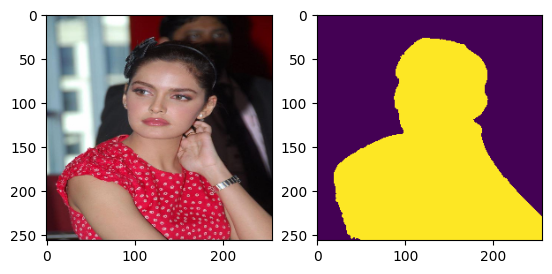

In [ ]:
import matplotlib.pyplot as plt

data = PeopleDataset(DATASET_PATH)

_, axarr = plt.subplots(1,2)

axarr[0].imshow(data[12]["image"].permute(1, 2, 0))
axarr[1].imshow(data[12]["mask"].permute(1, 2, 0))

plt.show()

# Построение U-NET

In [ ]:
import torch.nn as nn


class CNNBlock(nn.Module):
    """A single convolutional block: Conv2D -> BatchNorm -> ReLU."""

    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=0):
        super(CNNBlock, self).__init__()

        # Sequentially apply Conv -> BatchNorm -> ReLU
        self.seq_block = nn.Sequential(
            nn.Conv2d(
                in_channels, out_channels, kernel_size, stride, padding, bias=False
            ),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.seq_block(x)


class CNNBlocks(nn.Module):
    """A stack of `n_conv` CNNBlock modules."""

    def __init__(self, n_conv, in_channels, out_channels, padding):
        super(CNNBlocks, self).__init__()

        self.layers = nn.ModuleList()
        for i in range(n_conv):
            # Add CNNBlock to the list
            self.layers.append(CNNBlock(in_channels, out_channels, padding=padding))
            # After the first conv, in_channels becomes out_channels for subsequent blocks
            in_channels = out_channels

    def forward(self, x):
        """Pass input through all CNNBlocks sequentially."""
        for layer in self.layers:
            x = layer(x)
        return x


class Encoder(nn.Module):
    """Encoder module with multiple downsampling steps using CNNBlocks and MaxPooling."""

    def __init__(self, in_channels, out_channels, padding, n_down=4):
        super(Encoder, self).__init__()

        self.enc_layers = nn.ModuleList()

        # Create `n_down` downsampling stages
        for _ in range(n_down):
            self.enc_layers += [
                CNNBlocks(
                    n_conv=2,
                    in_channels=in_channels,
                    out_channels=out_channels,
                    padding=padding,
                ),  # Two convolutions
                nn.MaxPool2d(2, 2),  # Downsample by a factor of 2
            ]
            # Update channel sizes for the next stage
            in_channels = out_channels
            out_channels = 2 * out_channels  # Feature maps

        # Final block without downsampling
        self.enc_layers.append(
            CNNBlocks(
                n_conv=2,
                in_channels=in_channels,
                out_channels=out_channels,
                padding=padding,
            )
        )

    def forward(self, x):
        connections = []

        for layer in self.enc_layers:
            if isinstance(layer, CNNBlocks):
                x = layer(x)
                connections.append(x)
            else:
                x = layer(x)

        return x, connections


class Decoder(nn.Module):
    def __init__(self, in_channels, out_channels, exit_channels, padding, n_up=4):
        super(Decoder, self).__init__()

        self.exit_channels = exit_channels
        self.layers = nn.ModuleList()

        for i in range(n_up):
            self.layers += [
                nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
                CNNBlocks(
                    n_conv=2,
                    in_channels=in_channels,
                    out_channels=out_channels,
                    padding=padding,
                ),
            ]

            in_channels //= 2
            out_channels //= 2

        self.layers.append(
            nn.Conv2d(in_channels, self.exit_channels, kernel_size=1, padding=0)
        )

    def forward(self, x, connections):
        connections.pop(-1)
        for layer in self.layers:
            if isinstance(layer, CNNBlocks):
                connections_current = connections.pop(-1)
                x = torch.cat([x, connections_current], dim=1)
                x = layer(x)
            else:
                x = layer(x)
        return x


class UNET(nn.Module):
    def __init__(
        self, in_channels, first_out_channels, exit_channels, n_down=4, padding=1
    ):
        super(UNET, self).__init__()
        self.encoder = Encoder(
            in_channels, first_out_channels, padding=padding, n_down=n_down
        )
        self.decoder = Decoder(
            first_out_channels
            * (2**n_down),  # downscaled (so increase n maps 2x n_down times)
            first_out_channels
            * (2 ** (n_down - 1)),  # we have 2x channels here, because need to concat
            exit_channels,
            padding=padding,
            n_up=n_down,
        )

    def forward(self, x):
        enc_out, connections = self.encoder(x)
        return self.decoder(enc_out, connections)

## train/test split


In [ ]:
test_data = data[:100]

train_dataset, test_dataset = torch.utils.data.random_split(test_data, [80, 20], generator=torch.Generator().manual_seed(42))

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True, num_workers=2)

## Первое обучение

Попробуем обучить модель на небольшой части датасета и посмотрим на результат метрик.

In [ ]:
from torch import optim

net = UNET(3, 16, 1)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(net.parameters(), lr=3e-4)

net = net.cuda()

In [ ]:
from tqdm.auto import tqdm

torch.cuda.empty_cache()

for epoch in tqdm(range(10)):
    for i, data in enumerate(train_loader, 0):
        x = data['image']
        y = data['mask']

        optimizer.zero_grad()
        outputs = net(x.cuda()) # (4, 10)

        loss = criterion(outputs, y.cuda())
        loss.backward()
        optimizer.step()

  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
from sklearn.metrics import jaccard_score, accuracy_score

def visualize_prediction(net, test_loader):
    net.eval()

    with torch.no_grad():
        for data in test_loader:
              x = data['image'].cuda()
              y = data['mask']

              pred = net(x)

              _, axarr = plt.subplots(1, 3, figsize=(8, 4))
              axarr[0].imshow(pred[0][0].detach().cpu().numpy() > 0)
              axarr[0].set_title('Prediction')
              axarr[1].imshow(y[0][0].detach().cpu().numpy())
              axarr[1].set_title('Mask')
              axarr[2].imshow(x[0][0].detach().cpu().numpy())
              axarr[2].set_title('Image')

              for ax in axarr:
                  ax.axis('off')

              plt.tight_layout()
              plt.show()
              break

def accuracy(net, loader):
    net.eval()

    with torch.no_grad():
        for data in loader:
              x = data['image'].cuda()
              y = data['mask'].cuda()

              preds = net(x)
              preds = (preds > 0.5).float()

              total_score = 0.0
              count = 0

              for preds, mask in zip(preds, y):
                pred_np = preds.squeeze().detach().cpu().numpy().astype(int).flatten()
                mask_np = mask.squeeze().detach().cpu().numpy().astype(int).flatten()

                score = accuracy_score(mask_np, pred_np)
                total_score += score
                count += 1

              return total_score / count

def jaccard_index(net, loader):
    net.eval()

    with torch.no_grad():
        for data in loader:
              x = data['image'].cuda()
              y = data['mask'].cuda()

              preds = net(x)
              preds = (preds > 0.5).float()

              total_score = 0.0
              count = 0

              for preds, mask in zip(preds, y):
                pred_np = preds.squeeze().detach().cpu().numpy().astype(int).flatten()
                mask_np = mask.squeeze().detach().cpu().numpy().astype(int).flatten()

                score = jaccard_score(mask_np, pred_np, average='binary')
                total_score += score
                count += 1

              return total_score / count

def calc_loss(net, loader):
    net.eval()

    val_loss = 0.0

    with torch.no_grad():
        for val_data in loader:
            x = val_data['image'].cuda()
            y = val_data['mask'].cuda()

            preds = net(x)
            val_loss += criterion(preds, y).item()

    val_loss /= len(loader)

    return val_loss


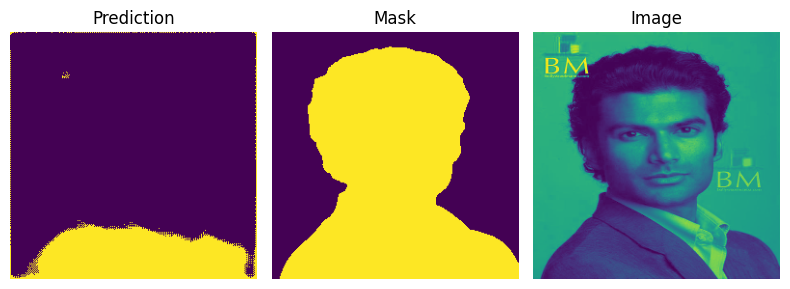

Jaccard index: 0.13401924359672862
Accuracy: 0.46437225341796873


In [ ]:
visualize_prediction(net, test_loader)
print(f"Jaccard index: {jaccard_index(net, test_loader)}")
print(f"Accuracy: {accuracy(net, test_loader)}")

# Переобучение модели
Теперь попробуем переобучить модель на совсем маленьком датасете.

In [ ]:
train_dataset, test_dataset = torch.utils.data.random_split(test_data, [4, 96], generator=torch.Generator().manual_seed(42))

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=8, shuffle=True, num_workers=2)

print(f"Dataset length\nTrain: {len(train_dataset)}\nTest: {len(test_dataset)}")

Dataset length
Train: 4
Test: 96


In [ ]:
net = UNET(3, 16, 1)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(net.parameters(), lr=3e-4)

net = net.cuda()

torch.cuda.empty_cache()

accuracy_dict = {"train": [], "test": []}
jaccard_dict = {"train": [], "test": []}
loss_dict = {"train": [], "test": []}

EPOCHS = 200

for epoch in tqdm(range(EPOCHS)):
    val_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        x = data['image']
        y = data['mask']

        optimizer.zero_grad()
        outputs = net(x.cuda())

        loss = criterion(outputs, y.cuda())
        val_loss += loss.item()
        loss.backward()
        optimizer.step()

    accuracy_dict["train"].append(accuracy(net, train_loader))
    jaccard_dict["train"].append(jaccard_index(net, train_loader))
    loss_dict["train"].append(val_loss / len(train_loader))

    accuracy_dict["test"].append(accuracy(net, test_loader))
    jaccard_dict["test"].append(jaccard_index(net, test_loader))
    loss_dict["test"].append(calc_loss(net, test_loader))

  0%|          | 0/200 [00:00<?, ?it/s]

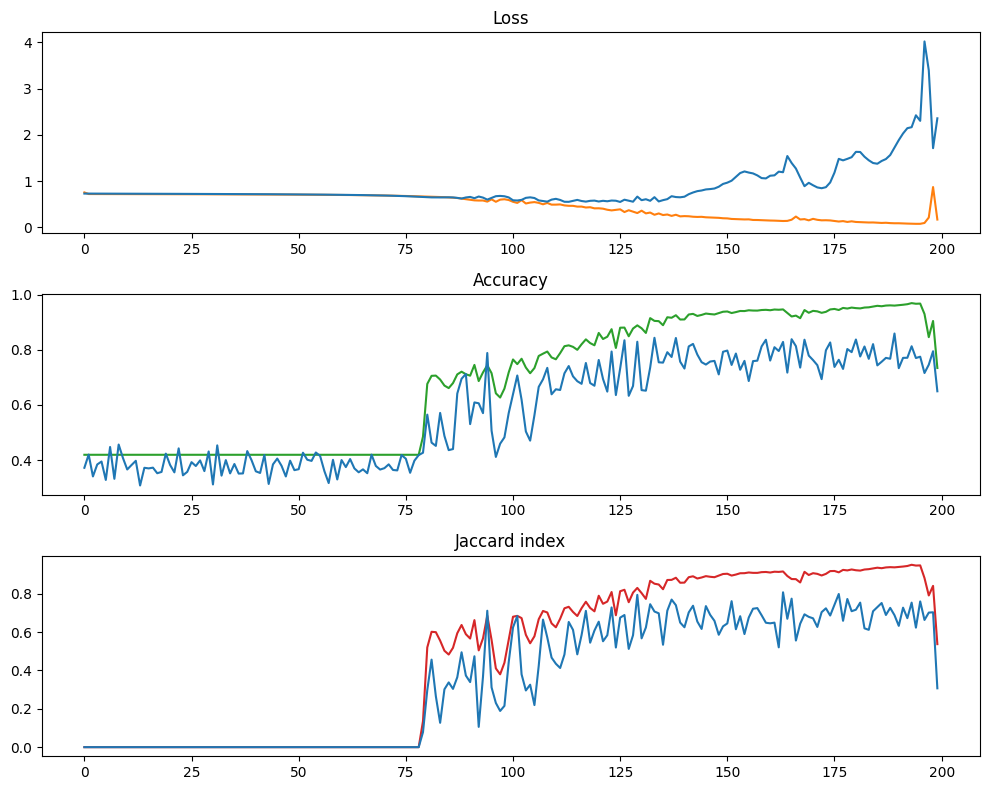

In [ ]:
plt.figure(figsize=(10, 8))

plt.subplot(3,1,1)
plt.plot(range(EPOCHS), loss_dict["train"], color='C1')
plt.plot(range(EPOCHS), loss_dict["test"], color='C0')

plt.title("Loss")

plt.subplot(3,1,2)
plt.plot(range(EPOCHS), accuracy_dict["train"], color='C2')
plt.plot(range(EPOCHS), accuracy_dict["test"], color='C0')

plt.title("Accuracy")

plt.subplot(3,1,3)
plt.plot(range(EPOCHS), jaccard_dict["train"], color='C3')
plt.plot(range(EPOCHS), jaccard_dict["test"], color='C0')


plt.title("Jaccard index")
plt.tight_layout()

plt.show()

Исходя из полученных метрик можно сказать, что удалось переобучить модель. *Training loss* достаточно быстро падает, в то время как validation loss растёт.

# Самые плохие предсказания
Попробуем посмотреть, какие результаты выдаёт переобучившаяся модель для *test dataset*.

In [ ]:
import numpy as np

def visualize_jaccard_worst(net, loader, n: int):
    net.eval()

    all_preds = []
    all_masks = []
    all_images = []
    all_scores = []

    with torch.no_grad():
        for data in loader:
            x = data['image'].cuda()
            y = data['mask'].cuda()

            preds = net(x)
            preds = (preds > 0.5).float()

            for pred, mask, img in zip(preds, y, x):
                pred_np = pred.squeeze().detach().cpu().numpy().astype(int).flatten()
                mask_np = mask.squeeze().detach().cpu().numpy().astype(int).flatten()

                score = jaccard_score(mask_np, pred_np, average='binary')

                all_preds.append(pred)
                all_masks.append(mask)
                all_images.append(img)
                all_scores.append(score)

    score_array = np.array(all_scores)
    worst_indices = score_array.argsort()[:n]

    _, axarr = plt.subplots(3, n, figsize=(3 * n, 6))

    for i, idx in enumerate(worst_indices):
        axarr[0, i].imshow(all_preds[idx][0].detach().cpu().numpy()  > 0)
        axarr[0, i].set_title('Prediction')

        axarr[1, i].imshow(all_masks[idx][0].detach().cpu().numpy())
        axarr[1, i].set_title('Mask')

        axarr[2, i].imshow(all_images[idx][0].detach().cpu().numpy())
        axarr[2, i].set_title('Image')

    for row in axarr:
        for ax in row:
            ax.axis('off')

    plt.tight_layout()
    plt.show()

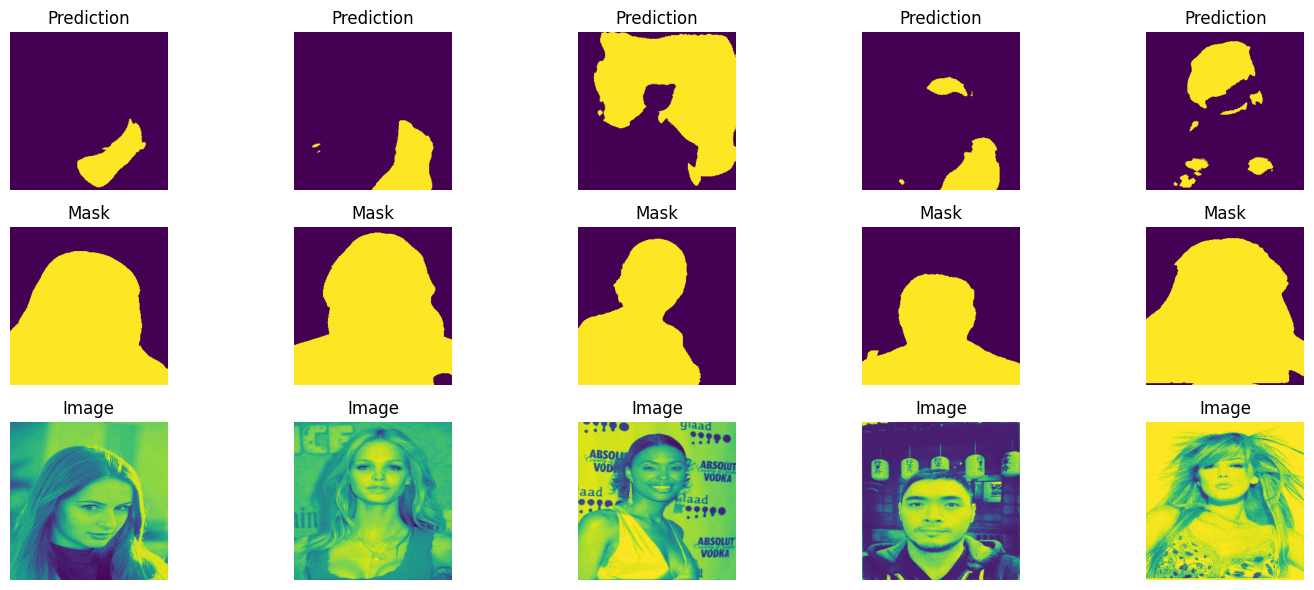

In [ ]:
visualize_jaccard_worst(net, test_loader, 5)

# Подбор оптимального времени обучения
Зафиксируем параметры и попробуем получить оптимальное время обучения, за которое модель не успеет переобучиться, но уже сможет показать вменяемые результаты.

In [ ]:
jaccard_dict = {"train": [], "test": []}

EPOCHS = [1, 10, 50, 100, 200, 300]

for epochs_num in tqdm(EPOCHS):
  net = UNET(3, 16, 1)
  criterion = nn.BCEWithLogitsLoss()
  optimizer = optim.Adam(net.parameters(), lr=3e-4)

  net = net.cuda()

  torch.cuda.empty_cache()

  for epoch in range(epochs_num):
      val_loss = 0.0
      for i, data in enumerate(train_loader, 0):
          x = data['image']
          y = data['mask']

          optimizer.zero_grad()
          outputs = net(x.cuda())

          loss = criterion(outputs, y.cuda())
          val_loss += loss.item()
          loss.backward()
          optimizer.step()

  jaccard_dict["train"].append(jaccard_index(net, train_loader))
  jaccard_dict["test"].append(jaccard_index(net, test_loader))

  0%|          | 0/6 [00:00<?, ?it/s]

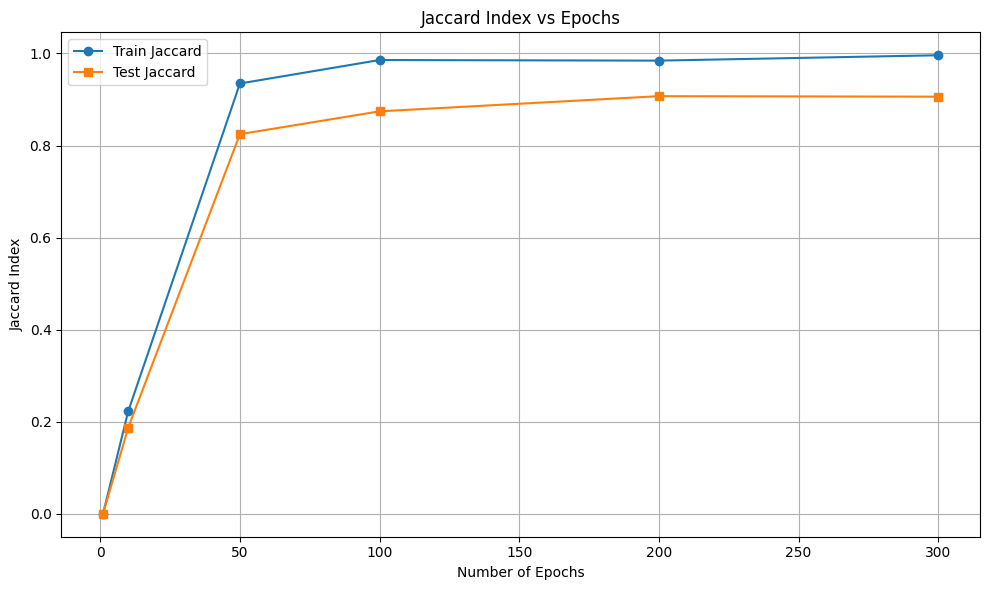

In [ ]:
plt.figure(figsize=(10, 6))

plt.plot(EPOCHS, jaccard_dict["train"], label='Train Jaccard', marker='o')
plt.plot(EPOCHS, jaccard_dict["test"], label='Test Jaccard', marker='s')

plt.xlabel("Number of Epochs")
plt.ylabel("Jaccard Index")
plt.title("Jaccard Index vs Epochs")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Оптимальным количеством эпох на данном датасете можно считать 100, так как далее результат не будет становиться значительно лучше.

# Аугментации

In [ ]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

aug = A.Compose([
    A.RandomRotate90(),
    A.RandomCrop(200,200),
    A.RGBShift(r_shift_limit=100, g_shift_limit=100, b_shift_limit=100, p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.Resize(height=256, width=256, p=1)
])

In [ ]:
aug_data = PeopleDataset(DATASET_PATH, aug)[:1500]

train_dataset, test_dataset = torch.utils.data.random_split(aug_data, [1000, 500], generator=torch.Generator().manual_seed(42))

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True, num_workers=2)

Shape: torch.Size([3, 256, 256])


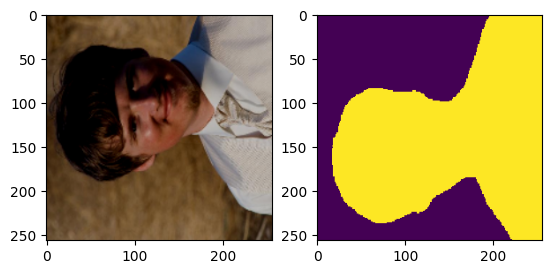

In [ ]:
from random import Random

_, axarr = plt.subplots(1,2)

i = Random().randint(0, len(aug_data)-1)

print(f"Shape: {aug_data[i]['image'].shape}")

axarr[0].imshow(aug_data[i]["image"].permute(1, 2, 0).detach().cpu().numpy())
axarr[1].imshow(aug_data[i]["mask"].permute(1, 2, 0))

plt.show()

Теперь обучим модель и замерим метрики

In [ ]:
net = UNET(3, 16, 1)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(net.parameters(), lr=3e-4)

net = net.cuda()

torch.cuda.empty_cache()

accuracy_dict = {"train": [], "test": []}
jaccard_dict = {"train": [], "test": []}
loss_dict = {"train": [], "test": []}

EPOCHS = 200

for epoch in tqdm(range(EPOCHS)):
    for i, data in enumerate(train_loader, 0):
        x = data['image']
        y = data['mask']

        optimizer.zero_grad()
        outputs = net(x.cuda())

        loss = criterion(outputs, y.cuda())
        loss.backward()
        optimizer.step()

    accuracy_dict["test"].append(accuracy(net, test_loader))
    jaccard_dict["test"].append(jaccard_index(net, test_loader))
    loss_dict["train"].append(calc_loss(net, test_loader))

  0%|          | 0/200 [00:00<?, ?it/s]

Accuracy: 0.8849692344665527, Jaccard: 0.8498868462424701


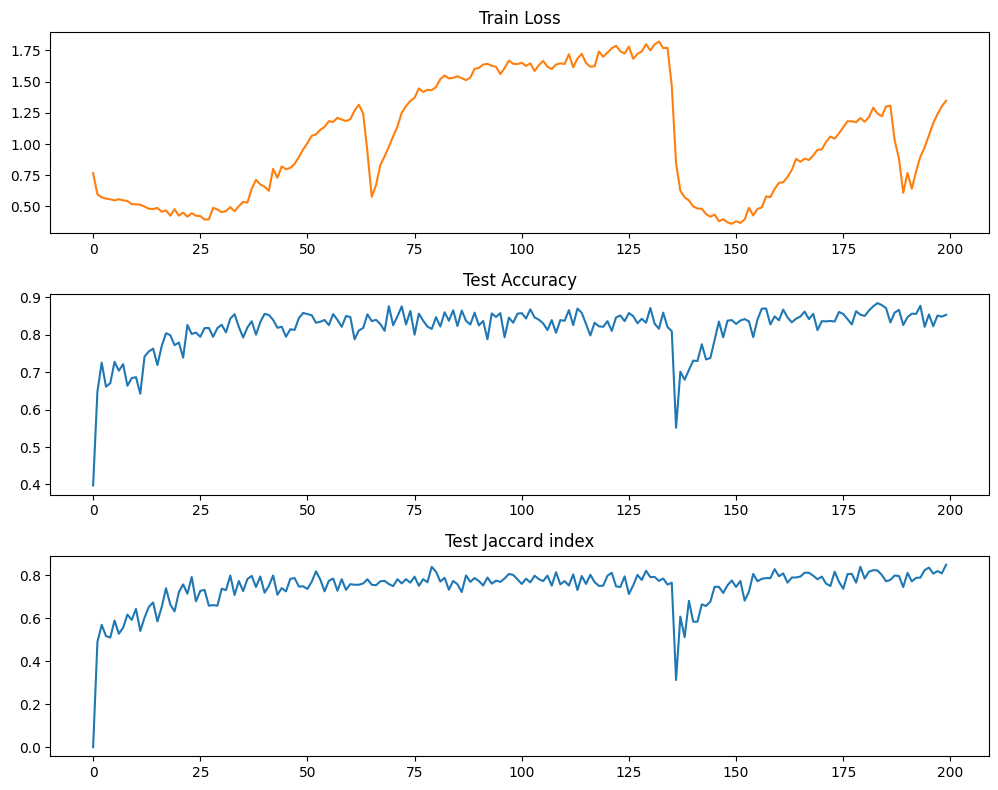

In [ ]:
print(f"Accuracy: {max(accuracy_dict['test'])}, Jaccard: {max(jaccard_dict['test'])}")

plt.figure(figsize=(10, 8))

plt.subplot(3,1,1)
plt.plot(range(EPOCHS), loss_dict["train"], color='C1')

plt.title("Train Loss")

plt.subplot(3,1,2)
plt.plot(range(EPOCHS), accuracy_dict["test"], color='C0')

plt.title("Test Accuracy")

plt.subplot(3,1,3)
plt.plot(range(EPOCHS), jaccard_dict["test"], color='C0')


plt.title("Test Jaccard index")
plt.tight_layout()

plt.show()

В результате получилось улучшить ключевые метрики для гораздо большего датасета.

# Новая архитектура

Теперь попробуем улучшить качество предсказаний, меняя архитектуру модели.
- *Dropout* в каждом блоке, для предотвращения переобучения
- Добавлены дополнительные слои в начале обучения
- Дополнительный 1x1 conv + Relu слой в каждом блоке
- Реализована новая loss-функция BCE+Jaccard

In [ ]:
import torch.nn as nn
import torch.nn.functional as F


class CNNBlock(nn.Module):
    """A single convolutional block: Conv2D -> BatchNorm -> ReLU."""

    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        super(CNNBlock, self).__init__()

        # Sequentially apply Conv -> BatchNorm -> ReLU
        self.seq_block = nn.Sequential(
            nn.Conv2d(
                in_channels, out_channels, kernel_size, stride, padding, bias=False
            ),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Dropout2d(0.3),
            nn.Conv2d(out_channels, out_channels, kernel_size=1),  # Mix channels
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.seq_block(x)


class CNNBlocks(nn.Module):
    """A stack of `n_conv` CNNBlock modules."""

    def __init__(self, n_conv, in_channels, out_channels, padding=1):
        super(CNNBlocks, self).__init__()

        self.layers = nn.ModuleList()

        for i in range(n_conv):
            # Add CNNBlock to the list
            self.layers.append(CNNBlock(in_channels, out_channels, padding=padding))
            in_channels = out_channels

    def forward(self, x):
        """Pass input through all CNNBlocks sequentially."""
        for layer in self.layers:
            x = layer(x)
        return x


class Encoder(nn.Module):
    """Encoder module with multiple downsampling steps using CNNBlocks and MaxPooling."""

    def __init__(self, in_channels, out_channels, padding=1, n_down=4):
        super(Encoder, self).__init__()

        self.enc_layers = nn.ModuleList()

        # Create `n_down` downsampling stages
        for _ in range(n_down):
            self.enc_layers += [
                CNNBlocks(
                    n_conv=2,
                    in_channels=in_channels,
                    out_channels=out_channels,
                    padding=padding,
                ),  # Two convolutions
                nn.MaxPool2d(2, 2),  # Downsample by a factor of 2
            ]
            # Update channel sizes for the next stage
            in_channels = out_channels
            out_channels = 2 * out_channels  # Feature maps

        # Final block without downsampling
        self.enc_layers.append(
            CNNBlocks(
                n_conv=2,
                in_channels=in_channels,
                out_channels=out_channels,
                padding=padding,
            )
        )

    def forward(self, x):
        connections = []

        for layer in self.enc_layers:
            if isinstance(layer, CNNBlocks):
                x = layer(x)
                connections.append(x)
            else:
                x = layer(x)

        return x, connections


class Decoder(nn.Module):
    def __init__(self, in_channels, out_channels, exit_channels, padding=1, n_up=4):
        super(Decoder, self).__init__()

        self.exit_channels = exit_channels
        self.layers = nn.ModuleList()

        for i in range(n_up):
            self.layers += [
                nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
                CNNBlocks(
                    n_conv=2,
                    in_channels=in_channels,
                    out_channels=out_channels,
                    padding=padding,
                ),
            ]

            in_channels //= 2
            out_channels //= 2

        self.layers.append(
            nn.Conv2d(in_channels, self.exit_channels, kernel_size=1, padding=0)
        )

    def forward(self, x, connections):
        connections.pop(-1)
        for layer in self.layers:
            if isinstance(layer, CNNBlocks):
                connections_current = connections.pop(-1)
                x = torch.cat([x, connections_current], dim=1)
                x = layer(x)
            else:
                x = layer(x)
        return x


class UNET(nn.Module):
    def __init__(
        self, in_channels, first_out_channels, exit_channels, n_down=4, padding=1
    ):
        super(UNET, self).__init__()
        self.encoder = Encoder(
            in_channels, first_out_channels, padding=padding, n_down=n_down
        )
        self.decoder = Decoder(
            first_out_channels
            * (2**n_down),  # downscaled (so increase n maps 2x n_down times)
            first_out_channels
            * (2 ** (n_down - 1)),  # we have 2x channels here, because need to concat
            exit_channels,
            padding=padding,
            n_up=n_down,
        )

    def forward(self, x):
        enc_out, connections = self.encoder(x)
        return self.decoder(enc_out, connections)

class JaccardLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(JaccardLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        # flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        #intersection is equivalent to True Positive count
        #union is the mutually inclusive area of all labels & predictions
        intersection = (inputs * targets).sum()
        total = (inputs + targets).sum()
        union = total - intersection

        IoU = (intersection + smooth)/(union + smooth)

        return 1 - IoU

class ComboLoss(nn.Module):
    def __init__(self, alpha=0.5):
        super().__init__()
        self.alpha = alpha
        self.bce = nn.BCEWithLogitsLoss()
        self.jaccard = JaccardLoss()

    def forward(self, inputs, targets):
        bce = self.bce(inputs, targets)
        jaccard = self.jaccard(torch.sigmoid(inputs), targets)
        return self.alpha * bce + (1 - self.alpha) * jaccard

In [ ]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

aug = A.Compose([
    A.RandomRotate90(),
    A.RandomCrop(200,200),
    A.RGBShift(r_shift_limit=100, g_shift_limit=100, b_shift_limit=100, p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.Resize(height=256, width=256, p=1)
])

aug_data = PeopleDataset(DATASET_PATH, aug)

train_dataset, test_dataset = torch.utils.data.random_split(aug_data, [1500, 500], generator=torch.Generator().manual_seed(42))

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True, num_workers=2)

In [ ]:
net = UNET(3, 16, 1)
criterion = ComboLoss()
optimizer = optim.Adam(net.parameters(), lr=3e-4)

net = net.cuda()

torch.cuda.empty_cache()

EPOCHS = 200

for epoch in tqdm(range(EPOCHS)):
    for i, data in enumerate(train_loader, 0):
        x = data['image']
        y = data['mask']

        optimizer.zero_grad()
        outputs = net(x.cuda())

        loss = criterion(outputs, y.cuda())
        loss.backward()
        optimizer.step()

print(f"Result accuracy: {accuracy(net, test_loader)}")
print(f"Result jaccard index: {jaccard_index(net, test_loader)}")

  0%|          | 0/200 [00:00<?, ?it/s]

Result accuracy: 0.9066462516784668
Result jaccard index: 0.8941911551806816


В результате удалось повысить значение ключевых метрик! Для *accuracy* прирост составил 0.1, для *jaccard index* 0.05.

# K-Fold
Попробуем применить технику k-fold и сравнить полученные результаты с обычным обучением.

  0%|          | 0/50 [00:00<?, ?it/s]

Fold 0 Jaccard: 0.9069 Loss: 0.6286


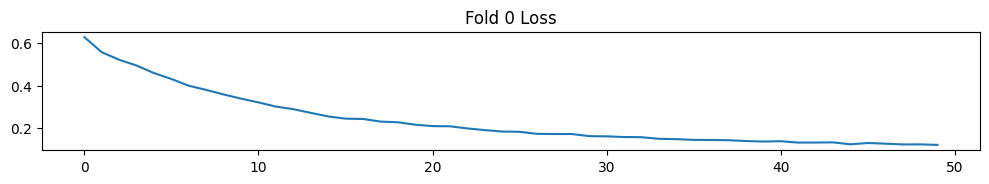

  0%|          | 0/50 [00:00<?, ?it/s]

Fold 1 Jaccard: 0.9253 Loss: 0.5619


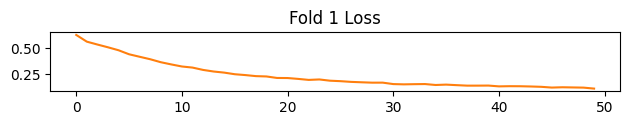

  0%|          | 0/50 [00:00<?, ?it/s]

Fold 2 Jaccard: 0.8991 Loss: 0.5242


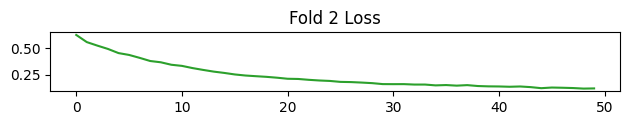

  0%|          | 0/50 [00:00<?, ?it/s]

Fold 3 Jaccard: 0.8657 Loss: 0.5082


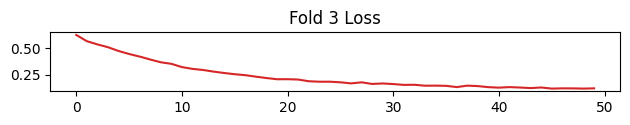

  0%|          | 0/50 [00:00<?, ?it/s]

Fold 4 Jaccard: 0.8602 Loss: 0.4655


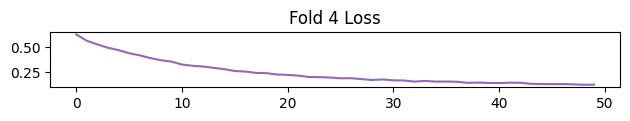

In [ ]:
from sklearn.model_selection import KFold
from torch.utils.data import Subset, DataLoader

K = 5

dataset = PeopleDataset(DATASET_PATH, aug)

kfold = KFold(n_splits=K, shuffle=True, random_state=42)

plt.figure(figsize=(10, 8))
fold_metrics = []

for i, (train_index, test_index) in enumerate(kfold.split(dataset)):
    train_subset = Subset(dataset, train_index)
    test_subset = Subset(dataset, test_index)

    train_loader = DataLoader(train_subset, batch_size=32, shuffle=True, num_workers=2)
    test_loader = DataLoader(test_subset, batch_size=32, shuffle=True, num_workers=2)

    # Train
    net = UNET(3, 16, 1)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(net.parameters(), lr=3e-4)

    net = net.cuda()

    torch.cuda.empty_cache()

    EPOCHS = 50

    loss_results = []

    for epoch in tqdm(range(EPOCHS)):
        val_loss = 0.0

        for _, data in enumerate(train_loader, 0):
            x = data['image']
            y = data['mask']

            optimizer.zero_grad()
            outputs = net(x.cuda())

            loss = criterion(outputs, y.cuda())
            val_loss += loss.item()
            loss.backward()
            optimizer.step()


        loss_results.append(val_loss / len(train_loader))

    # Check jaccard index
    jaccard = jaccard_index(net, test_loader)
    print(f"Fold {i} Jaccard: {jaccard:.4f} Loss: {loss_results[i]:.4f}")
    fold_metrics.append(jaccard)

    # Draw loss plot for every fold
    plt.subplot(K,1,i+1)
    plt.plot(range(EPOCHS), loss_results, color=f'C{i}')

    plt.title(f"Fold {i} Loss")

    plt.tight_layout()
    plt.show()

In [ ]:
import numpy as np

# Final results
print(f"Max jaccard: {np.max(fold_metrics)}")
print(f"Mean jaccard: {np.mean(fold_metrics)}")

Max jaccard: 0.9252939575007815
Mean jaccard: 0.8914361111060909


## Сравнение результатов

Результаты, полученные при обучении моделей на разных фолдах, сходятся с результатами при обычном обучении. Из этого можно сделать вывод, что модель действительно умеет предсказывать реальные данные и не была подвержена переобучению.

# Заключение

- Была обучена UNet-модель для задачи сегментации на небольшом датасете. Выполнены необходимые подготовительные шаги: train/test split, добавление метрик Jaccard Index, Accuracy. Также добавлены некоторые другие функции для отслеживания качества моделей.

- Выполнено переобучение модели — достигнуто почти идеальное качество на train выборке.

- Модель обучена на полном train-наборе, построены кривые loss и Jaccard для train/val. Подобрано оптимальное количество эпох.

- Визуализированы topN плохих предсказаний.

- Проведены эксперименты по улучшению качества без изменения архитектуры, с помощью аугментаций.

- Была изменена архитектура, что тоже дало некоторое улучшение метрик.

- Сделана 5-fold кросс-валидация, результаты проанализированы.